In [ ]:
# Fix notebook metadata for GitHub rendering
import json
from google.colab import files

# This just ensures proper metadata
print("Notebook metadata fixed for GitHub compatibility")

Notebook metadata fixed for GitHub compatibility


In [ ]:
# Install required libraries
!pip install datasets transformers accelerate evaluate rouge-score -q

print("Setup complete! Ready to load data!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
Setup complete! Ready to load data!


In [ ]:
import torch
from transformers import pipeline

# Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
  print(f"GPU Name: {torch.cuda.get_device_name(0)}")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
from datasets import load_dataset
import pandas as pd

print("Loading dataset...")

# Load the dataset - we'll start with a sample first
dataset = load_dataset("mlfoundations-dev/github-issues", split="train", streaming=True)

print("Dataset loaded in streaming mode!")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/799 [00:00<?, ?B/s]

Dataset loaded in streaming mode!


In [ ]:
# Get first 5 examples to understand the structure
examples = []
for i, example in enumerate(dataset):
    examples.append(example)
    if i >= 4:  # Get 5 examples (0-4)
        break

# Convert to DataFrame for easy viewing
df_sample = pd.DataFrame(examples)

print("Dataset Structure:")
print(f"Number of columns: {len(df_sample.columns)}")
print(f"\nColumn names:\n{df_sample.columns.tolist()}")
print("\n" + "="*80)
print("\n First example:")
for key, value in examples[0].items():
    print(f"\n{key}:")
    print(f"  {str(value)[:200]}")  # Show first 200 characters

# Check the fields we care about most
print("="*80)
print("TITLE (what we want to predict):")
print(examples[0]['title'])
print("\n" + "="*80)
print("BODY (what we'll use as input):")
print(examples[0]['body'][:500])  # First 500 characters
print("\n (truncated)")
print("\n" + "="*80)

# Check if there are None/empty values
print("\n Data Quality Check:")
for i, ex in enumerate(examples):
    has_title = ex['title'] is not None and len(ex['title']) > 0
    has_body = ex['body'] is not None and len(ex['body']) > 0
    print(f"Example {i}: Title={'yes' if has_title else 'no'}, Body={'yes' if has_body else 'no'}")

Dataset Structure:
Number of columns: 12

Column names:
['repo_name', 'topic', 'issue_number', 'title', 'body', 'state', 'created_at', 'updated_at', 'url', 'labels', 'user_login', 'comments_count']


 First example:

repo_name:
  BlinkDL/RWKV-LM

topic:
  pytorch

issue_number:
  127

title:
  finetune for other languages?

body:
  how I can fine-tune for vietnamese for dialog chatbot ? Thanks guys

state:
  closed

created_at:
  2023-05-25T08:48:41Z

updated_at:
  2023-06-07T16:56:20Z

url:
  https://github.com/BlinkDL/RWKV-LM/issues/127

labels:
  []

user_login:
  batman-do

comments_count:
  3
📝 TITLE (what we want to predict):
finetune for other languages?

BODY (what we'll use as input):
how I can fine-tune for vietnamese for dialog chatbot ? Thanks guys

 (truncated)


 Data Quality Check:
Example 0: Title=yes, Body=yes
Example 1: Title=yes, Body=yes
Example 2: Title=yes, Body=yes
Example 3: Title=yes, Body=yes
Example 4: Title=yes, Body=yes


Loading 10,000 samples for detailed analysis...

Loaded 10000 samples
Clean samples (with both title and body): 9672
Data quality: 96.7%

TEXT LENGTH STATISTICS
      Metric Title Length (words) Body Length (words)
       Count                 9672                9672
        Mean                  7.1               166.3
     Std Dev                  4.5               309.5
         Min                    1                   1
         25%                    4                  39
Median (50%)                    6                  90
         75%                    9                 190
         Max                  151               13128


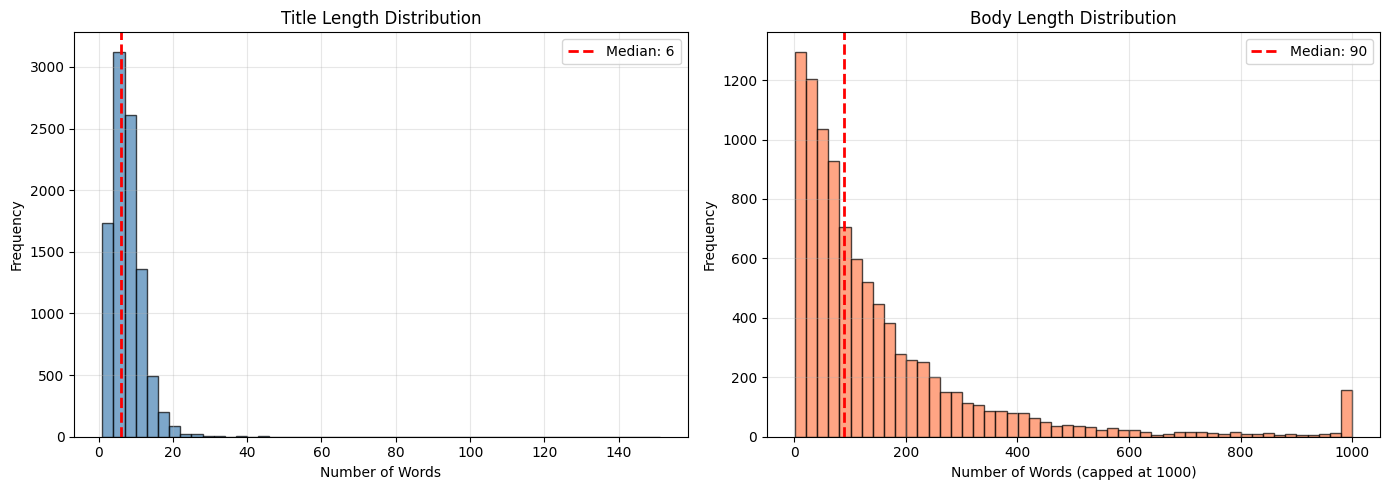

In [ ]:
print("Loading 10,000 samples for detailed analysis...")

# Load 10k samples
sample_size = 10000
samples = []
for i, example in enumerate(dataset):
    samples.append(example)
    if i >= sample_size - 1:
        break

df = pd.DataFrame(samples)

# Calculate lengths
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()) if x else 0)
df['body_length'] = df['body'].apply(lambda x: len(str(x).split()) if x else 0)

# Filter out empty entries
df_clean = df[(df['title_length'] > 0) & (df['body_length'] > 0)]

print(f"\nLoaded {len(df)} samples")
print(f"Clean samples (with both title and body): {len(df_clean)}")
print(f"Data quality: {len(df_clean)/len(df)*100:.1f}%")

# Create statistics table
stats_data = {
    'Metric': ['Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median (50%)', '75%', 'Max'],
    'Title Length (words)': [
        len(df_clean),
        f"{df_clean['title_length'].mean():.1f}",
        f"{df_clean['title_length'].std():.1f}",
        f"{df_clean['title_length'].min():.0f}",
        f"{df_clean['title_length'].quantile(0.25):.0f}",
        f"{df_clean['title_length'].median():.0f}",
        f"{df_clean['title_length'].quantile(0.75):.0f}",
        f"{df_clean['title_length'].max():.0f}"
    ],
    'Body Length (words)': [
        len(df_clean),
        f"{df_clean['body_length'].mean():.1f}",
        f"{df_clean['body_length'].std():.1f}",
        f"{df_clean['body_length'].min():.0f}",
        f"{df_clean['body_length'].quantile(0.25):.0f}",
        f"{df_clean['body_length'].median():.0f}",
        f"{df_clean['body_length'].quantile(0.75):.0f}",
        f"{df_clean['body_length'].max():.0f}"
    ]
}

stats_df = pd.DataFrame(stats_data)
print("\n" + "="*80)
print("TEXT LENGTH STATISTICS")
print("="*80)
print(stats_df.to_string(index=False))

# Visualizations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title lengths
axes[0].hist(df_clean['title_length'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Length Distribution')
axes[0].axvline(df_clean['title_length'].median(), color='red', linestyle='--',
                linewidth=2, label=f'Median: {df_clean["title_length"].median():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Body lengths (capped at 1000 for visualization)
body_capped = df_clean['body_length'].clip(upper=1000)
axes[1].hist(body_capped, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Number of Words (capped at 1000)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Body Length Distribution')
axes[1].axvline(df_clean['body_length'].median(), color='red', linestyle='--',
                linewidth=2, label=f'Median: {df_clean["body_length"].median():.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("SAMPLE EXAMPLES FROM DATASET")
print("="*80)

# Create examples table
examples_data = []
for i in [0, 100, 500, 1000, 2000]:
    if i < len(df_clean):
        row = df_clean.iloc[i]
        examples_data.append({
            'Example': i+1,
            'Title': str(row['title'])[:60] + '...' if len(str(row['title'])) > 60 else str(row['title']),
            'Body Preview': str(row['body'])[:80].replace('\n', ' ') + '...',
            'Title Words': int(row['title_length']),
            'Body Words': int(row['body_length'])
        })

examples_df = pd.DataFrame(examples_data)
print(examples_df.to_string(index=False))

print("\n" + "="*80)
print("DETAILED VIEW - Example 1")
print("="*80)
row = df_clean.iloc[0]
print(f"Repository: {row['repo_name']}")
print(f"Issue Number: {row['issue_number']}")
print(f"State: {row['state']}")
print(f"\nTITLE: {row['title']}")
print(f"\nBODY:\n{row['body'][:500]}")
print(f"\n... (showing first 500 characters of {row['body_length']} word body)")


SAMPLE EXAMPLES FROM DATASET
 Example                                                           Title                                                                           Body Preview  Title Words  Body Words
       1                                   finetune for other languages?                 how I can fine-tune for vietnamese for dialog chatbot ? Thanks guys...            4          12
     101 How to detect the noise, breaks and multi-person speak in a ...    Hello, I am not in the audio field. I would like to ask, for a reference audio, ...           12          61
     501              Improve translation in part 6 on feature selection    [A comment on Kaggle](https://www.kaggle.com/kashnitsky/topic-6-feature-engineer...            8           4
    1001 onnx.helper.make_attribute_ref does not set attr.ref_attr_na... # Bug Report\r \r ### Describe the bug\r onnx.helper.make_attribute_ref does not cr...            5          35
    2001                                  Pac